<a href="https://colab.research.google.com/github/tqtg/tutorials/blob/master/unsupervised_learning_with_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Learning with Autoencoder

This tutorial demonstrates the concept of unsupervised learning by training a simple autoencoder model on MNIST dataset. 

## Setup

In [0]:
!pip install --quiet tensorflow==2.1.0 imageio seaborn plotly

In [0]:
!rm *.png *.gif

In [0]:
import os
import sys
import time

import PIL
import glob
import imageio
import IPython

import numpy as np
import pandas as pd

import plotly
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

print("System version: {}".format(sys.version))
print("TensorFlow version: {}".format(tf.__version__))

System version: 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
TensorFlow version: 2.1.0


## Data Preparation

### Load MNIST dataset

Each MNIST image is originally a vector of 784 integers, each of which is between 0-255 and represents the intensity of a pixel.

In [0]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
print("Training size:", train_images.shape[0])
print("Test size:", test_images.shape[0])

train_images = train_images.reshape(-1, 784).astype('float32')
test_images = test_images.reshape(-1, 784).astype('float32')

# Normalizing the images to the range of [0., 1.]
train_images /= 255.
test_images /= 255.

Training size: 60000
Test size: 10000


### Let's show some images from training data

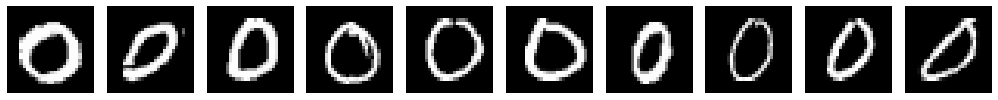

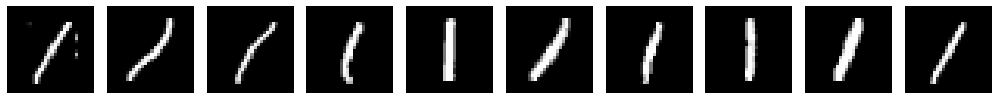

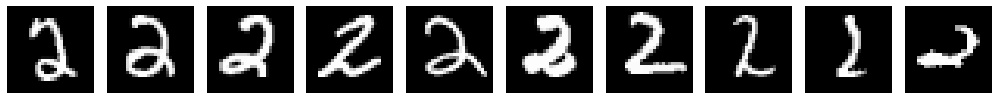

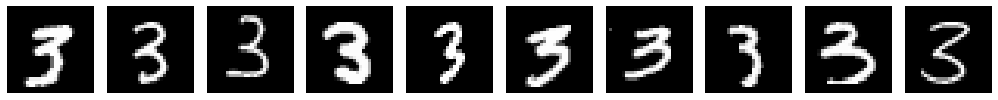

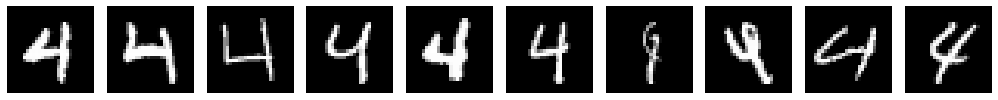

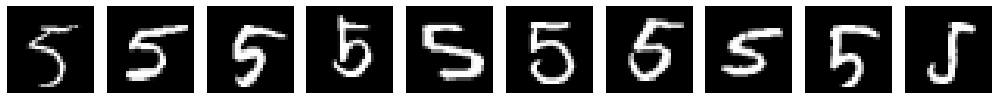

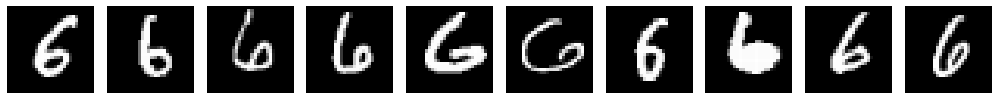

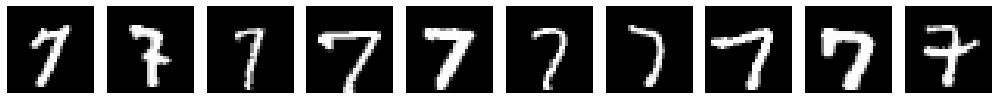

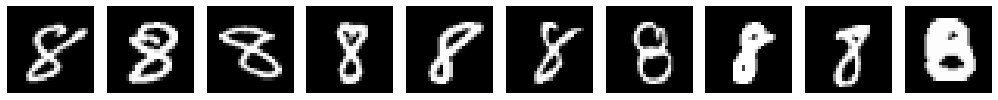

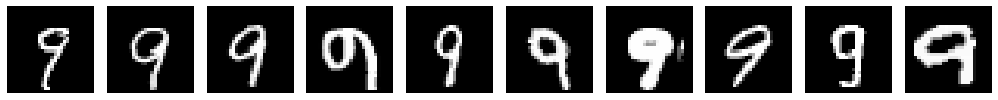

In [0]:
def save_and_show_images(images, fname):
  _images = images.reshape(-1, 28, 28, 1)
  fig = plt.figure(figsize=(14, 1.5))
  for i in range(min(10, len(_images))):
    plt.subplot(1, 10, i + 1)
    plt.imshow(_images[i, :, :, 0], cmap="gray")
    plt.axis("off")
  fig.tight_layout()
  plt.savefig(fname)
  plt.show()

for i in range(10):
  idx = np.where(train_labels == i)[0]
  selected_idx = np.random.choice(idx, 10, replace=False)
  save_and_show_images(train_images[selected_idx], "train_images_{}.png".format(i))

### Build TF dataset

We are going to train our model using TensorFlow framework. First, we need to build training and test datasets based on TF Dataset API.

In [0]:
BATCH_SIZE = 100

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_images.shape[0]).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_images.shape[0]).batch(BATCH_SIZE)

## Model Training

### Autoencoder architecture

We will learn a very simple autoencoder with linear transformation for both encoder and decoder. 

In [0]:
class Autoencoder(tf.keras.Model):
  def __init__(self, latent_dim):
    super().__init__()
    self.latent_dim = latent_dim
    # encoder weights
    self.W_e = tf.Variable(tf.random.normal([784, latent_dim], stddev=0.01), 
                           name="W_e")
    self.b_e = tf.Variable(tf.zeros(latent_dim), name="b_e")
    # decoder weights
    self.W_d = tf.Variable(tf.random.normal([latent_dim, 784], stddev=0.01), 
                           name="W_d")
    self.b_d = tf.Variable(tf.zeros(784), name="b_d")

  def encode(self, x):
    h = tf.matmul(x, self.W_e) + self.b_e
    return h

  def decode(self, h):
    _x = tf.matmul(h, self.W_d) + self.b_d
    return _x
    
  def call(self, x):
    return self.decode(self.encode(x))

### Define the loss function and the optimizer

We train our autoencoder by minizing the reconstruction error between our model predictions and the original images. The model weights will be optimized using Stochastic Gradient Descent.

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

@tf.function
def compute_loss(model, x):
    x_ = model(x)
    l2_loss = tf.square(x - x_)
    loss = tf.reduce_sum(l2_loss, axis=1)
    return tf.reduce_mean(loss)

@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

### Training

Epoch: 100, Test set loss: 9.0274, time elapse for current epoch 1.01s
Decoded images:


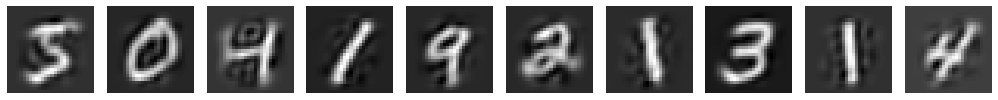

In [0]:
NUM_EPOCHS = 100
LATENT_DIM = 50

model = Autoencoder(LATENT_DIM)

for epoch in range(1, NUM_EPOCHS + 1):
  tick = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer)
  tock = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
      loss(compute_loss(model, test_x))
    IPython.display.clear_output(wait=False)
    print("Epoch: {}, Test set loss: {:.4f}, "
          "time elapse for current epoch {:.2f}s".format(epoch,
                                                         loss.result(),
                                                         tock - tick))
    print("Decoded images:")
    decoded_images = model(train_images[:10]).numpy()
    save_and_show_images(decoded_images, "image_at_epoch_{:04d}.png".format(epoch))

Original images:


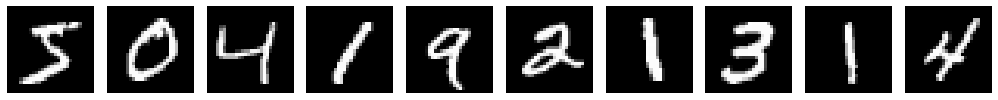

In [0]:
print("Original images:")
save_and_show_images(train_images[:10], "train_images.png")

Training progress animation:


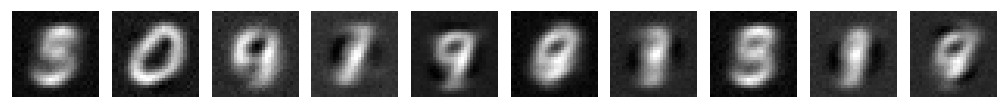

In [0]:
gif_file = "ae.gif"

with imageio.get_writer(gif_file, mode="I") as writer:
  filenames = glob.glob("image_at_epoch_*.png")
  filenames = sorted(filenames)
  last = -1
  for i, filename in enumerate(filenames):
    frame = 2 * (i ** 0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

print("Training progress animation:")
with open(gif_file, 'rb') as f:
  display(IPython.display.Image(data=f.read(), format='png'))

## Visualizing learned latent space

We would like to have some intuition how autoencoder preserves information in order to miniminzing the reconstruction error. One attempt is to analyse how the data is organized in the latent space.

Let's learn an autoencoder model with only 3-dimensional latent space so that we can easily visualize the data points.

Epoch: 100, Test set loss: 40.5091, time elapse for current epoch 0.86s
Decoded images:


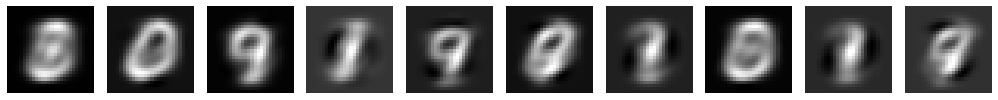

In [0]:
NUM_EPOCHS = 100
LATENT_DIM = 3

model3d = Autoencoder(LATENT_DIM)

for epoch in range(1, NUM_EPOCHS + 1):
  tick = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model3d, train_x, optimizer)
  tock = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
      loss(compute_loss(model3d, test_x))
    IPython.display.clear_output(wait=False)
    print("Epoch: {}, Test set loss: {:.4f}, "
          "time elapse for current epoch {:.2f}s".format(epoch,
                                                         loss.result(),
                                                         tock - tick))
    print("Decoded images:")
    decoded_images = model3d(train_images[:10]).numpy()
    save_and_show_images(decoded_images, "image_at_epoch_{:04d}.png".format(epoch))

For each class, let's pick a subset of images from the test set (e.g., 200 images). We will use the learned autoencoder encoding the images into the latent space.

In [0]:
# number of images per class
n = 200

data = np.empty((n * 10, LATENT_DIM), dtype=np.float32)
labels = np.empty(n * 10, dtype=np.int)

for i in range(10):
  idx = np.where(test_labels == i)[0]
  selected_idx = np.random.choice(idx, n, replace=False)
  data[i*n:(i+1)*n] = model3d.encode(test_images[selected_idx]).numpy()
  labels[i*n:(i+1)*n] = i

df = pd.DataFrame(data=data, columns=["x", "y", "z"])
df["label"] = labels

### Visualize encoded images in 2D

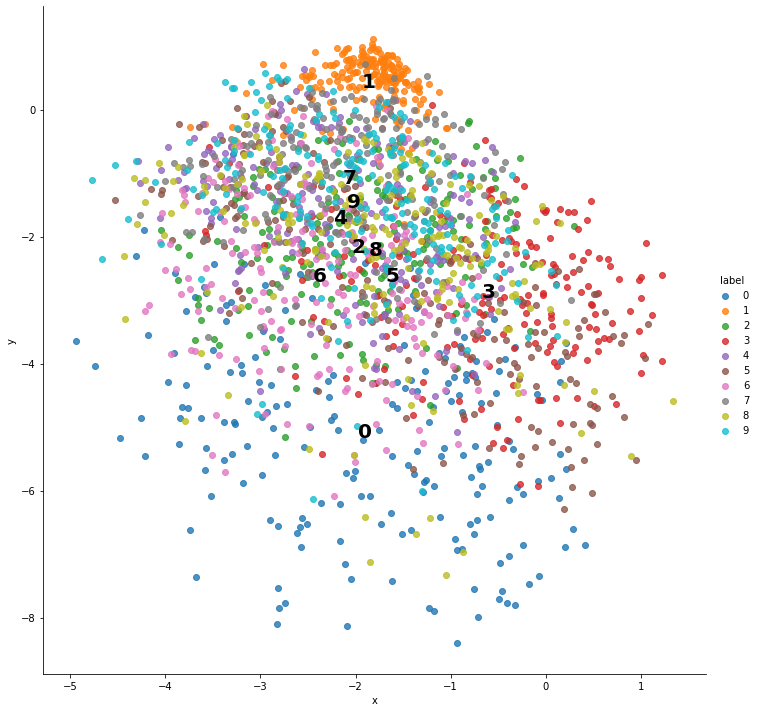

In [0]:
facet = sns.lmplot(data=df, x="x", y="y", hue="label", height=10.0,
                   fit_reg=False, legend=True, legend_out=True)

for label in range(10):
  plt.annotate(label,
               df.loc[df['label']==label,['x','y']].mean(),
               horizontalalignment='center',
               verticalalignment='center',
               size=20, weight='bold') 

### Visualize encoded images in 3D 

In [0]:
colors = ["blue", "orange", "green", "red", "purple", "brown", "pink", "gray", "olive", "cyan"]
scatters = []
clusters = []
for i in range(10):
  cluster = df.loc[df["label"] == i]
  scatters.append(dict(mode = "markers",
                       name = "Class {}".format(i),
                       type = "scatter3d",
                       x=cluster["x"], y=cluster["y"], z=cluster["z"],
                       marker = dict(size=2, color=colors[i])))
  clusters.append(dict(alphahull=5,
                       name="Class {}".format(i),
                       opacity=.1,
                       type="mesh3d",
                       x=cluster["x"], y=cluster["y"], z=cluster["z"],
                       color=colors[i], showscale=True))

layout = dict(title='Interactive Clusterring Effect in 3D',
              scene=dict(xaxis=dict(zeroline=True),
                         yaxis=dict(zeroline=True),
                         zaxis=dict(zeroline=True)))

fig = dict(data=scatters+clusters, layout=layout)
plotly.offline.iplot(fig, filename='mesh3d')

![alt text](https://drive.google.com/uc?id=10aScNO6hEYF7De2EcTqQQkCHRGeG-QPY)